In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.2.0+cu92


第一步：拿到数据集，观察数据集的形式



第二步：对拿到的数据集清理数据，如果是文本数据，清理数据，对于连续型数据标准化，对于连续型数据中的缺失值补充为零，对于离散型数据进行连续化，用pd.get_dummies()进行处理



第三步：清理完数据后，建立数据输入通道，建立模型，建立损失函数



第四步：编写训练数据的策略，进行训练



第五步：将训练好的模型进行checkpoint保存，如果需要CSV文件，则需要写csv文件的输出格式

拿到数据集，先观察数据集且清理数据

In [3]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')

In [6]:
#将训练数据和测试数据的维度信息输出，进行观察
print(train_data.shape)
print(test_data.shape)
print(train_data.head())
print(test_data.head())

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice 

可以看到训练数据中有81个特征信息，测试数据有80个特征信息，ID作为每一条数据的索引，我们将这条特征舍弃，方便进行后续处理，将特征信息中的连续数据进行数据清理（清洗掉不合理的数据集，剔除掉NAN数据），而且将其拉伸至同一分布中，将特征信息中离散型数据用0,1,2,3等数值进行处理

In [8]:
#将所有有效特征进行连接,训练数据集剔除了销售价格
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)
print(all_features.head())

(2919, 79)
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub    Inside      ...                 0        0    NaN   
1         Lvl    AllPub       FR2      ...                 0        0    NaN   
2         Lvl    AllPub    Inside      ...                 0        0    NaN   
3         Lvl    AllPub    Corner      ...                 0        0    NaN   
4         Lvl    AllPub       FR2      ...                 0        0    NaN   

  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0   NaN         

In [13]:
#对连续型数据做标准化，对于缺失值用标准化的值来代替
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)#用0来代替缺失值
print(numeric_features)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [14]:
#为离散值建立特征
#get_dummies：Convert categorical variable into dummy/indicator variables
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
object_features = all_features.dtypes[all_features.dtypes == 'object'].index
print(object_features)
print(all_features[object_features])
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
     MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0          RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1          RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2          RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3          

[2919 rows x 43 columns]
(2919, 331)


In [17]:
print(all_features.head())

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.067320    -0.202033 -0.217841     0.646073    -0.507197   1.046078   
1   -0.873466     0.501785 -0.072032    -0.063174     2.187904   0.154737   
2    0.067320    -0.061269  0.137173     0.646073    -0.507197   0.980053   
3    0.302516    -0.436639 -0.078371     0.646073    -0.507197  -1.859033   
4    0.067320     0.689469  0.518814     1.355319    -0.507197   0.947040   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2        ...          \
0      0.896679    0.525112    0.580807    -0.29308        ...           
1     -0.395536   -0.572152    1.177910    -0.29308        ...           
2      0.848819    0.334770    0.097856    -0.29308        ...           
3     -0.682695   -0.572152   -0.494856    -0.29308        ...           
4      0.753100    1.387248    0.468851    -0.29308        ...           

   SaleType_Oth  SaleType_WD  SaleType_nan  SaleCondition_Abnorml  \
0             0        

In [18]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)
#将所有的数据从Pandas类型转化为Numpy类型，方便后续进行处理
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

torch.Size([1460, 331])
torch.Size([1459, 331])
torch.Size([1460, 1])


将所有数据处理完后就要建立相应的模型，这里我们建立多层感知器模型，输入是预测房价所需要的数据特征，输出是房价的预测信息

In [29]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)#模型参数初始化
    return net
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [24]:
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
#Parameters: *tensors – tensors that have the same size of the first dimension.
#即第一个参数是数据的特征参数，第二个参数是相同大小的标签信息

In [25]:
#定义完模型后就要进行训练策略
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)#Dataset wrapping tensors
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

K折交叉验证
我们在模型选择、欠拟合和过拟合中介绍了 K 折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第i折交叉验证时所需要的训练和验证数据。

fold 0, train rmse 0.242103, valid rmse 0.222224
fold 1, train rmse 0.229122, valid rmse 0.265752
fold 2, train rmse 0.232669, valid rmse 0.237966
fold 3, train rmse 0.237303, valid rmse 0.218466
fold 4, train rmse 0.230602, valid rmse 0.258523
5-fold validation: avg train rmse 0.234360, avg valid rmse 0.240586


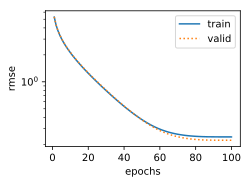

In [30]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

train rmse 0.230025


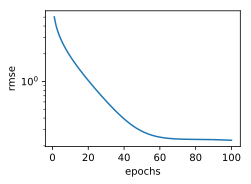

In [31]:
#用全部数据集来训练模型，并且生成csv
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
    # sample_submission_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)